<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/main_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install import_ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2975 sha256=e131c8bf462a767ba6ac1954e43274d94b12077a367128ff1b6adff6dd36d1e0
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [3]:
!wget https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/defs_common.ipynb -O "defs_common.ipynb"
from defs_common import *

--2020-01-03 08:52:32--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/defs_common.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6564 (6.4K) [text/plain]
Saving to: ‘defs_common.ipynb’

defs_common.ipynb   100%[===================>]   6.41K  --.-KB/s    in 0s      

2020-01-03 08:52:32 (81.5 MB/s) - ‘defs_common.ipynb’ saved [6564/6564]

importing Jupyter notebook from defs_common.ipynb


In [0]:
import cv2 as cv
import pandas as pd
import numpy as np
import random

In [9]:
!cp "./drive/My Drive/sudoku_acquisition_output.bz2" "./sudoku_acquisition_output.bz2"
dataset = pd.read_pickle("./sudoku_acquisition_output.bz2")
dataset

,input_image,input_digits,training
input_filename,,,
./v2_train/image1059.jpg,"[[[172, 171, 159], [174, 170, 165], [174, 170,...","[[0, 3, 0, 1, 4, 8, 2, 0, 0], [0, 4, 2, 0, 0, ...",True
./v2_train/image26.jpg,"[[[120, 130, 131], [119, 129, 130], [117, 127,...","[[6, 0, 1, 0, 8, 5, 0, 0, 4], [0, 0, 0, 3, 0, ...",True
./v2_train/image41.jpg,"[[[142, 162, 150], [142, 162, 150], [142, 162,...","[[7, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 1, 4, 0, ...",True
./v2_train/image19.jpg,"[[[148, 166, 154], [148, 166, 154], [147, 165,...","[[6, 0, 1, 0, 8, 5, 0, 0, 4], [0, 0, 0, 3, 0, ...",False
./v2_train/image22.jpg,"[[[149, 166, 156], [149, 166, 156], [149, 166,...","[[6, 0, 1, 0, 8, 5, 0, 0, 4], [0, 0, 0, 3, 0, ...",False
...,...,...,...
./dataset/009000800/IMG_8812.JPG,"[[[93, 98, 90], [95, 96, 95], [93, 95, 94], [9...","[[0, 0, 9, 0, 0, 0, 8, 0, 0], [0, 6, 0, 0, 0, ...",True
./dataset/009000800/IMG_8817.JPG,"[[[195, 195, 197], [196, 194, 200], [195, 196,...","[[0, 0, 9, 0, 0, 0, 8, 0, 0], [0, 6, 0, 0, 0, ...",True
./dataset/009000800/IMG_8822.JPG,"[[[15, 15, 14], [15, 15, 17], [14, 14, 16], [1...","[[0, 0, 9, 0, 0, 0, 8, 0, 0], [0, 6, 0, 0, 0, ...",True


# Introduction

In [0]:
demo_indices = np.random.permutation(len(dataset.index))[:4]

# Preprocessing

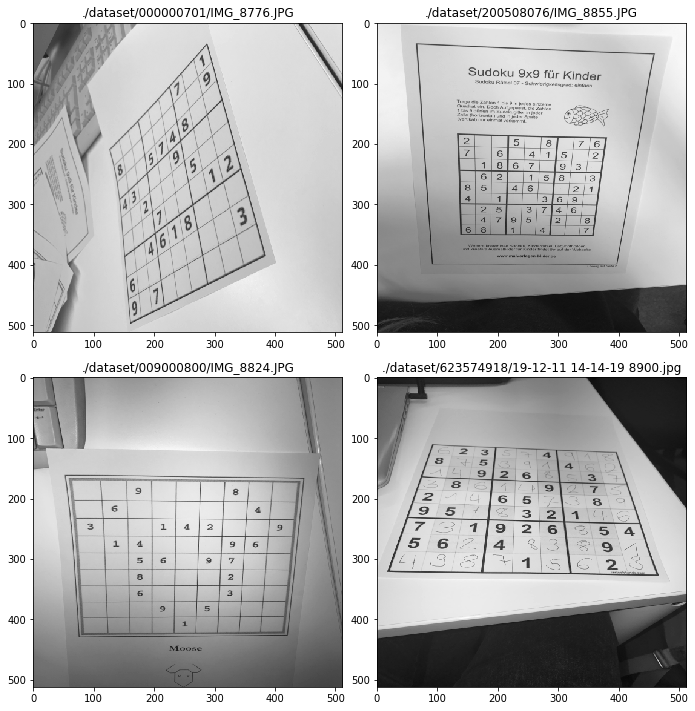

In [16]:
def convert_to_grayscale(image):
  return cv.cvtColor(image, cv.COLOR_RGB2GRAY)

dataset["gray_image"] = [convert_to_grayscale(x) for x in dataset["input_image"]]
show_images(dataset["gray_image"], dataset.index, cmap="gray", i_samples=demo_indices)

Grayscale images only have one "color" channel, but this one is still not binary.
For this reason we use thresholding, which maps values below some threshold x to "completely black" and values above x to "completely white".
More precisely we use a technique called "adaptive thresholding" which requires us to define a "block size".
The method `adaptiveThreshold` from OpenCV requires the block size to be specified by a number of pixels.
Because we accept different kinds of images with varying resolutions, we define it relative to the image resolution and then convert to an absolute number of pixels as required.


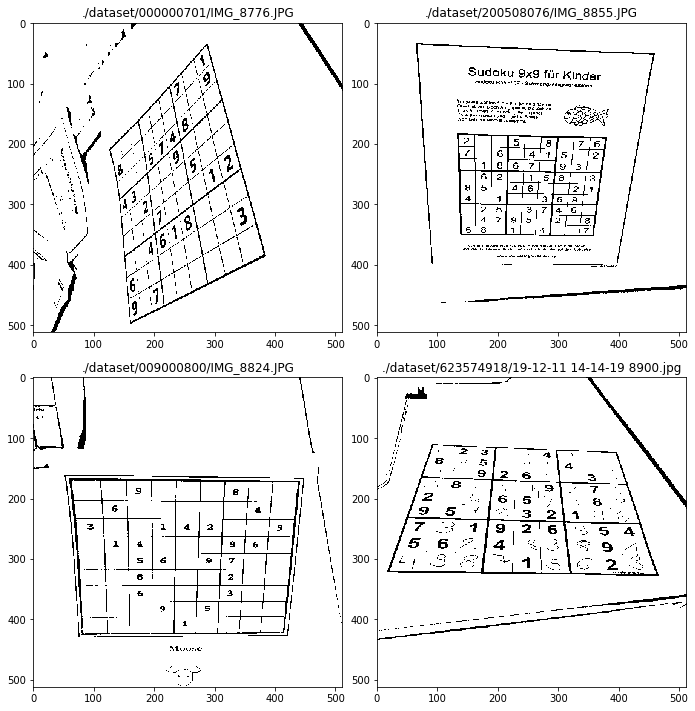

In [19]:
#@title Threshold Configuration { run: "auto" }
default_threshold_block_size = 0.1 #@param { type: "slider", min: 0, max: 1, step: 0.1 }
default_threshold_bias = 32 #@param { type:"slider", min: -255, max: 255, step: 1 }

def threshold_image(image, 
                    method=cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                    block_size=default_threshold_block_size, 
                    bias=default_threshold_bias):
  # convert relative block size to absolute block size
  width, height = image.shape
  block_size = int(block_size * min(width, height))
  # if block_size is even, we must make it uneven (see def. of adaptiveThreshold)
  if block_size % 2 == 0:
    block_size += 1
  return cv.adaptiveThreshold(image, 255, method, cv.THRESH_BINARY, block_size, bias)

dataset["thresh_image"] = [threshold_image(x) for x in dataset["gray_image"]]
show_images(dataset["thresh_image"], dataset.index, cmap="gray", i_samples=demo_indices)

# Contour Detection
Finally we can try to detect the shape of a Sudoku grid within each image.
As previously mentioned we do this using the method `findContours` provided by OpenCV.

In [0]:
def find_contours(image):
  # image must be inverted, because findContours treats white as foreground and black as background
  # if we don't invert the image, the image border will be detected as a contour
  image = cv.bitwise_not(image)
  contours, _ = cv.findContours(image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  return contours

contours = [find_contours(x) for x in dataset["thresh_image"]]

The set of found contours can be visualized using the method `drawContours` provided by OpenCV.

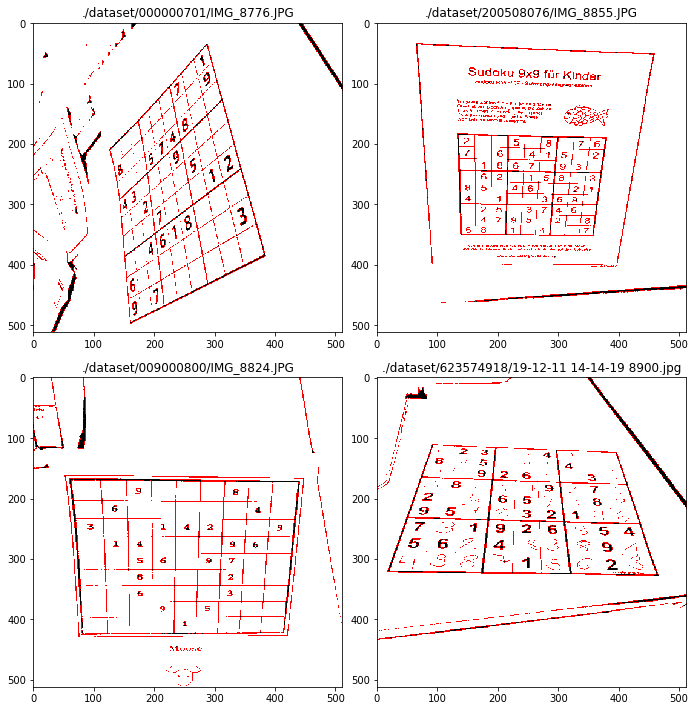

In [24]:
def draw_contours(image, contours, thickness=0.001, color=(0, 0, 255)):
  # convert image from grayscale to BGR
  image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
  height, width = image.shape[:2]
  thickness = (height + width) / 2 * thickness
  # draw contours using OpenCV
  if not any(x is None for x in contours):
    cv.drawContours(image, contours, -1, color, int(thickness))
  return cv.cvtColor(image, cv.COLOR_BGR2RGB)

dataset["contour_image"] = [draw_contours(x, y) for x, y in zip(dataset["thresh_image"], contours)]
show_images(dataset["contour_image"], dataset.index, i_samples=demo_indices)

# Contour Recognition

From all of the detected contours we now have to determine which contours are actually corresponding to our Sudoku grid.

## Filtering four sided contours

**Assumption**: The Sudoku grid always has a square border.

**Idea:** A square has exactly four sides. Thus we can filter out all contours having less than or more than four sides.

The contours generated by `findContours` can be very *wiggly* causing us to overestimate the actual number of sides.
To counter that, we approximate all contours using the method `approxPolyDP` that is also provided by OpenCV.

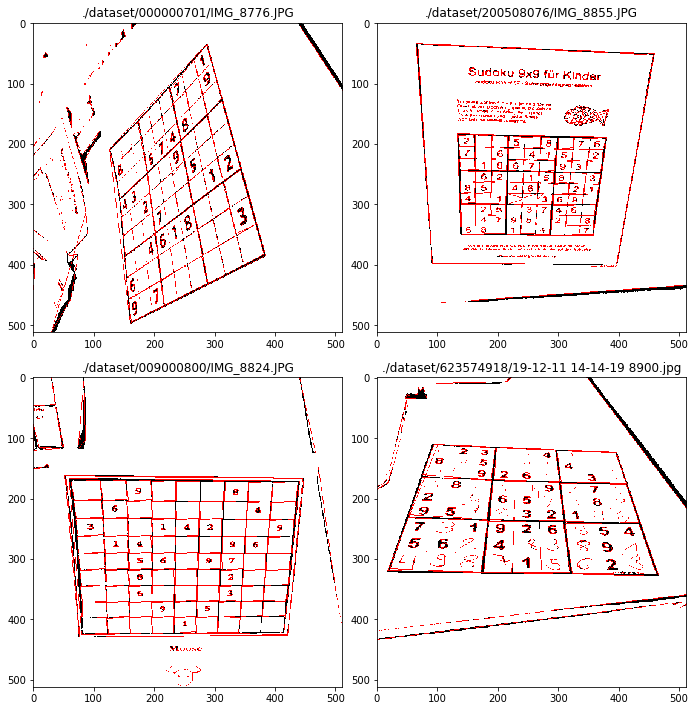

In [26]:
def approximate_contour(contour, precision=0.1):
  # convert relative precision to absolute precision (epsilon)
  _, _, width, height = cv.boundingRect(contour)
  epsilon = (width + height) / 2 * precision
  return cv.approxPolyDP(contour, epsilon, closed=True)

approximated_contours = [[approximate_contour(y) for y in x] for x in contours]
dataset["contour_image"] = [draw_contours(x, y) for x, y in zip(dataset["thresh_image"], approximated_contours)]
show_images(dataset["contour_image"], dataset.index, i_samples=demo_indices)

Now we can actually filter out all contours that are not foursided.

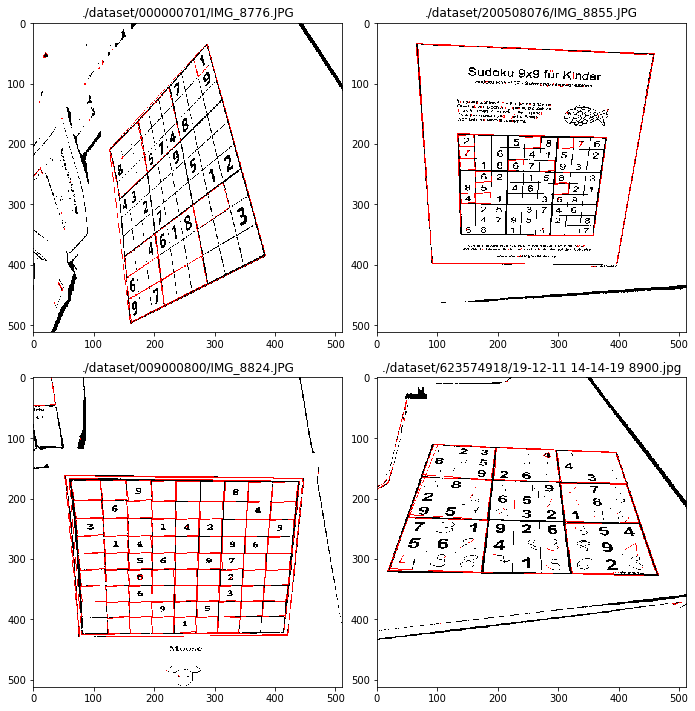

In [27]:
def get_foursided_contours(contours):
  candidates = []
  for contour in contours:
    if len(contour) != 4:
      continue
    candidates.append(contour)
  return candidates

foursided_contours = [get_foursided_contours(x) for x in approximated_contours]
dataset["contour_image"] = [draw_contours(x, y) for x, y in zip(dataset["thresh_image"], foursided_contours)]
show_images(dataset["contour_image"], dataset.index, i_samples=demo_indices)

But which of these foursided contours is our Sudoku square?

## Selecting largest contour

**Assumption:** The Sudoku grid is always the largest foursided object within all images.

**Idea:** Sort contours by area and choose the largest one.

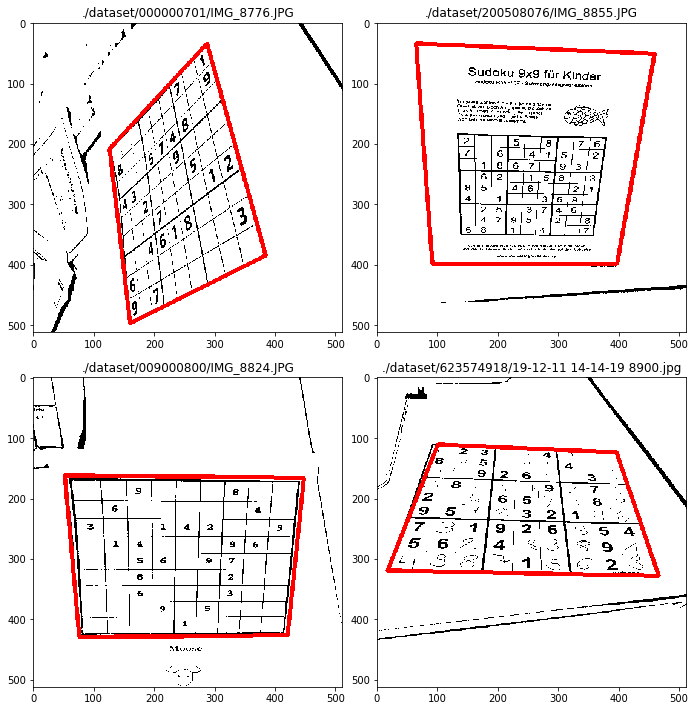

In [59]:
def get_largest_contour(contours):
  lengths = [cv.contourArea(x) for x in contours]
  if len(lengths) == 0:
    return None
  else:
    longest = np.argmax(lengths)
    return contours[longest]

dataset["contour"] = [get_largest_contour(x) for x in foursided_contours]
dataset["contour_image"] = [draw_contours(x, [y], thickness=0.01) for x, y in zip(dataset["thresh_image"], largest_contours)]
show_images(dataset["contour_image"], dataset.index, i_samples=demo_indices)

## Sanity checks

**Assumption**: Sudoku grid covers at least 25% of area within input image.

**Idea**: Filter out all contours that are smaller than this threshold.

In [0]:
def check_sudoku_contour(input_image, contour, threshold=0.1, **kwargs):
  if contour is None:
    return False
  width, height = input_image.shape[:2]
  total_image_area = width * height
  contour_area = cv.contourArea(contour)
  return contour_area / total_image_area > threshold

dataset["contour_valid"] = [check_sudoku_contour(x, y) for x, y in zip(dataset["input_image"], dataset["contour"])]

In [61]:
dataset_good = dataset[dataset["contour_valid"] == True]
print("%d Sudoku grids detected!" % len(dataset_good))

dataset_bad = dataset[dataset["contour_valid"] == False]
print("%d Sudoku grids NOT detected!" % len(dataset_bad))

207 Sudoku grids detected!
149 Sudoku grids NOT detected!


# Examples of detected Sudoku grids

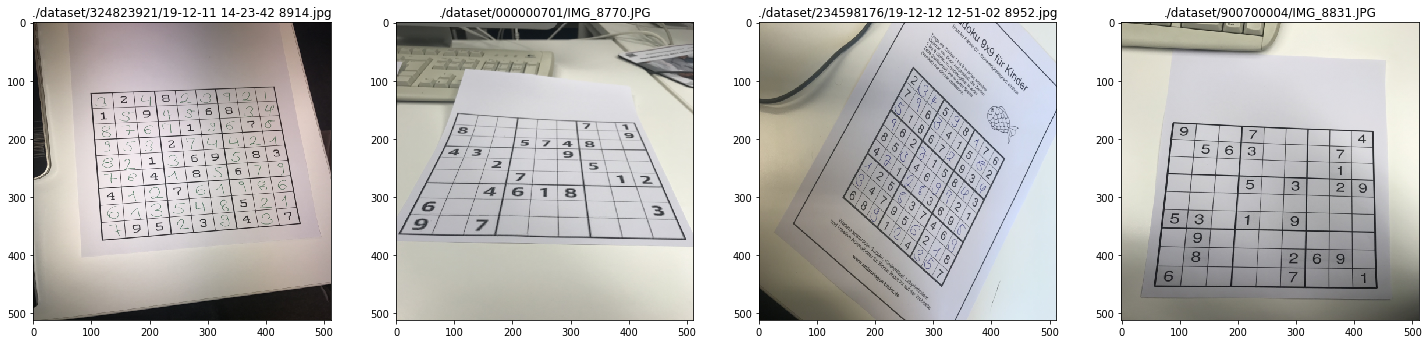

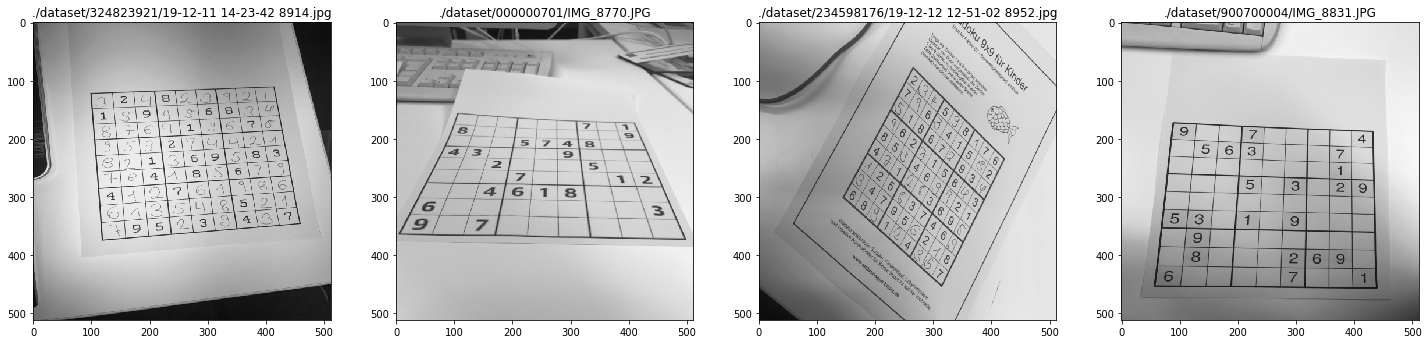

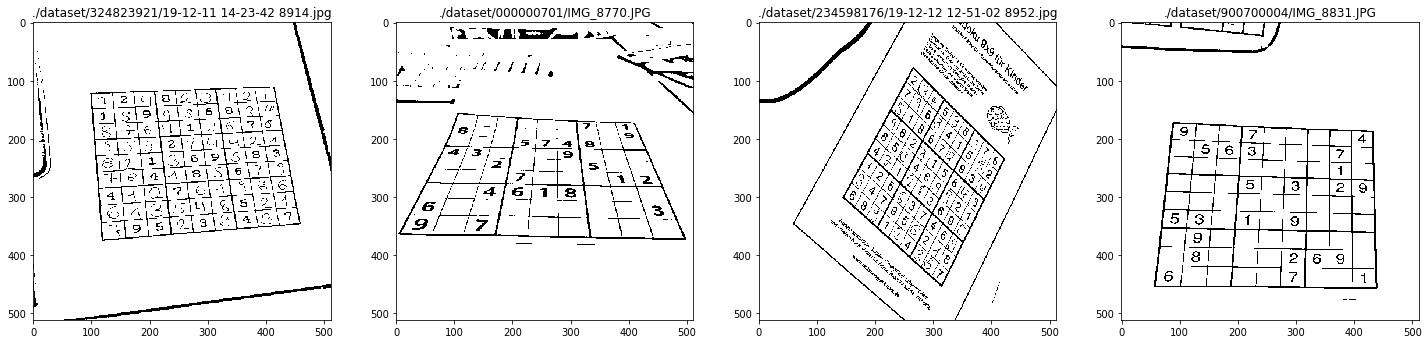

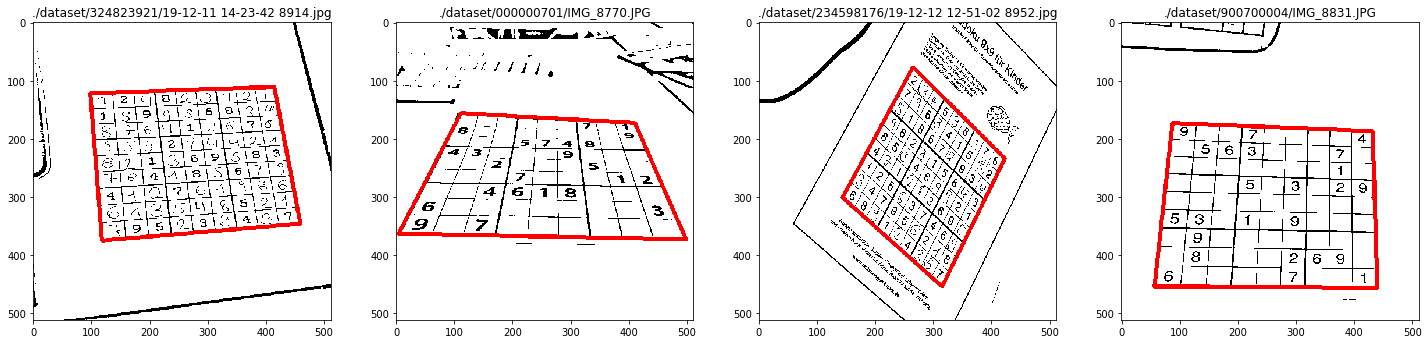

In [62]:
example_images = dataset_good.sample(n=4)
show_images(example_images["input_image"], example_images.index, rows=1)
show_images(example_images["gray_image"], example_images.index, cmap="gray", rows=1)
show_images(example_images["thresh_image"], example_images.index, cmap="gray", rows=1)
show_images(example_images["contour_image"], example_images.index, rows=1)

# Examples of undetected Sudoku grids

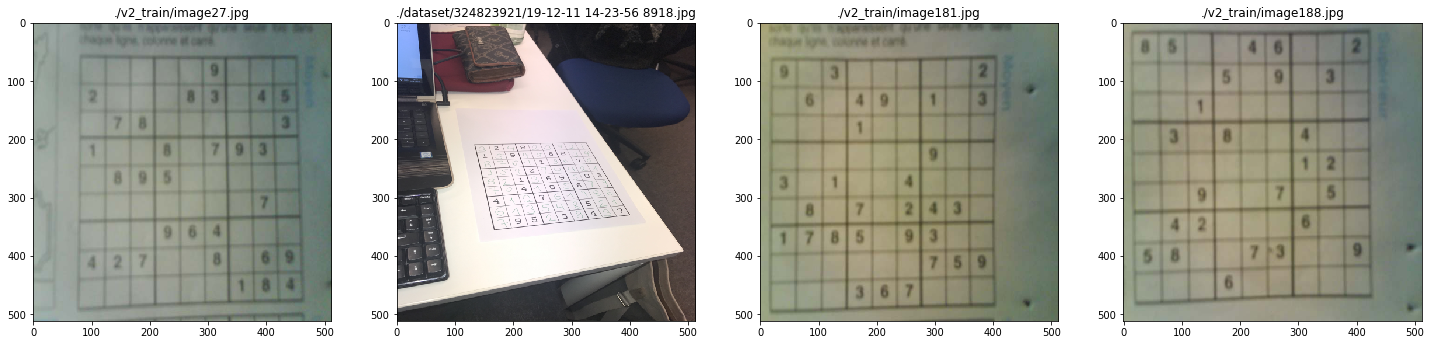

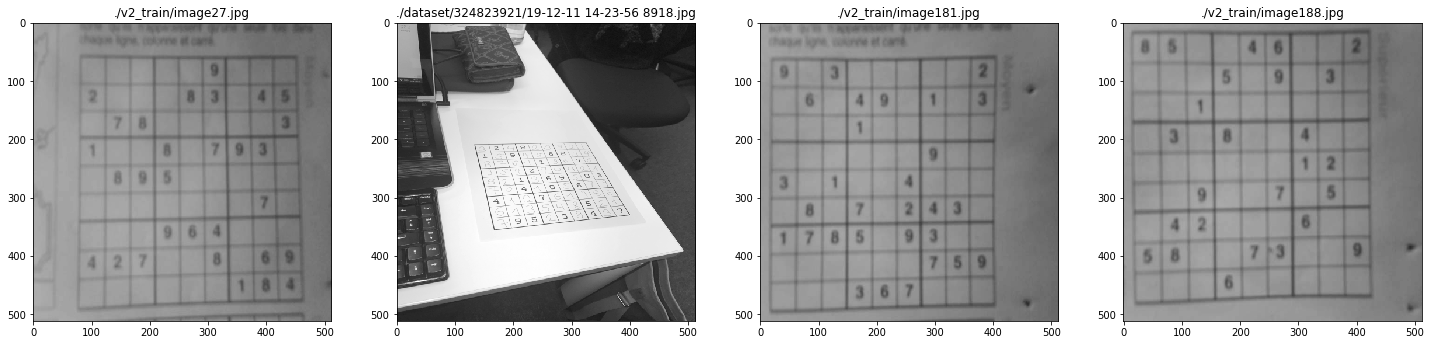

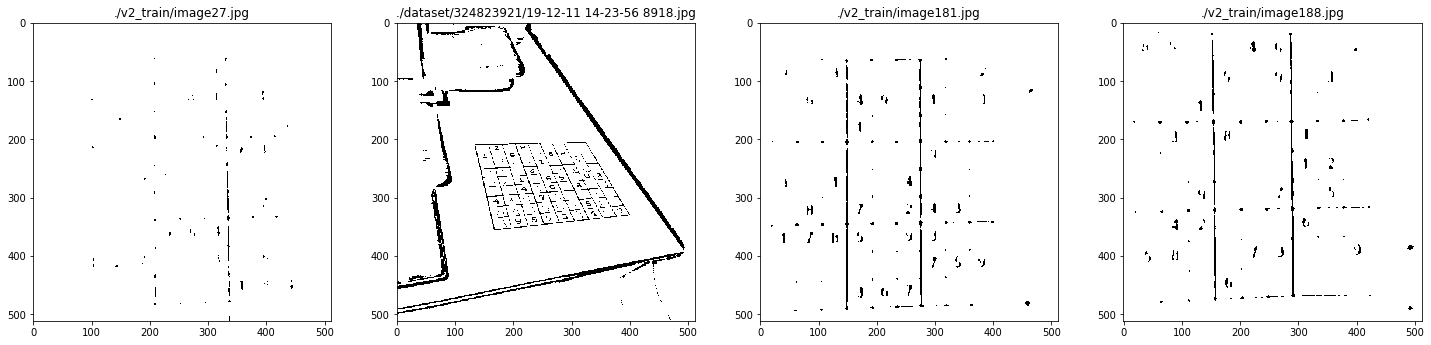

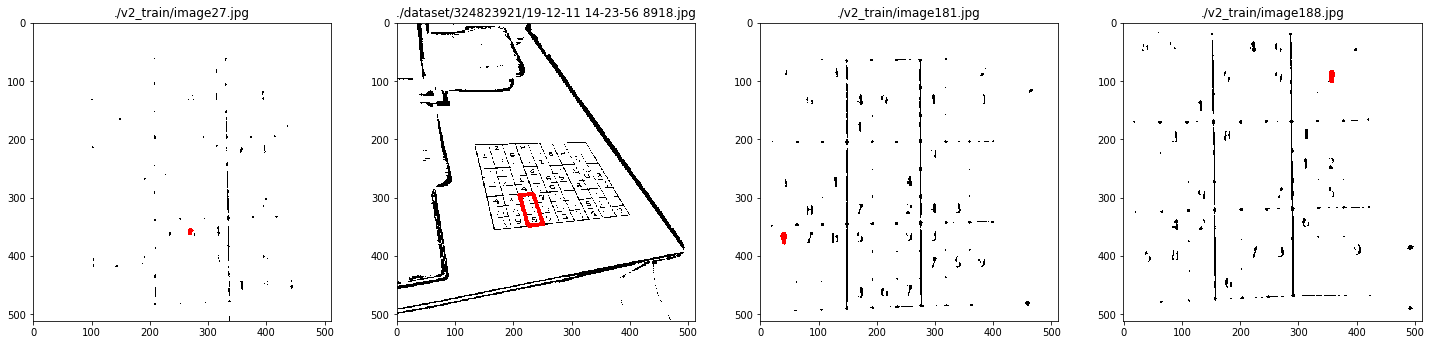

In [63]:
example_images = dataset_bad.sample(n=4)
show_images(example_images["input_image"], example_images.index, rows=1)
show_images(example_images["gray_image"], example_images.index, cmap="gray", rows=1)
show_images(example_images["thresh_image"], example_images.index, cmap="gray", rows=1)
show_images(example_images["contour_image"], example_images.index, rows=1)

# Export

In [0]:
df = pd.DataFrame({
    "input_filename": dataset_good.index,
    "contour": dataset_good["contour"]
}).set_index("input_filename")

In [65]:
df

,contour
input_filename,
./v2_train/image1059.jpg,"[[[64, 151]], [[66, 379]], [[444, 378]], [[434..."
./v2_train/image1006.jpg,"[[[57, 64]], [[50, 356]], [[456, 355]], [[445,..."
./v2_train/image1082.jpg,"[[[55, 110]], [[58, 420]], [[463, 413]], [[469..."
./v2_train/image204.jpg,"[[[399, 65]], [[97, 72]], [[95, 474]], [[407, ..."
./v2_train/image201.jpg,"[[[350, 36]], [[448, 42]], [[450, 313]], [[349..."
...,...
./dataset/009000800/IMG_8813.JPG,"[[[379, 131]], [[110, 179]], [[47, 388]], [[38..."
./dataset/009000800/IMG_8819.JPG,"[[[124, 39]], [[116, 381]], [[444, 357]], [[39..."
./dataset/009000800/IMG_8812.JPG,"[[[385, 30]], [[99, 160]], [[51, 421]], [[393,..."


In [0]:
df.to_pickle("./sudoku_detection_output.bz2")

In [0]:
!cp "./sudoku_detection_output.bz2" "./drive/My Drive/sudoku_detection_output.bz2"